In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from math import ceil
import numpy as np
from tqdm.auto import tqdm
from os import makedirs
from cost import degree_cost, uniform_cost
from seedset import random_seeds, cost_seeds_greedy, wtss
from influence import influence_diffusion
from eur import f1

# Initialization

makedirs(f"data/processed", exist_ok=True)

/home/valerio/Documents/influence_diffusion_benchmark/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 0. Parameters

In [2]:
DATASET_NAME = "lastfm_asia"
SS_STRATEGY = "wtss"
COST_FN = "degree"
NUM_STEPS = 30

## 1. Data preparation

### Read the data

In [3]:
G = nx.Graph()
with open(f"data/raw/{DATASET_NAME}_edges.csv", "r") as f:
    f.readline()  # Skip header
    for line in f:
        a, b = map(int, line.strip().split(","))
        G.add_edge(a, b)
print(f"Number of nodes: {G.number_of_nodes()}")
G = nx.Graph(nx.subgraph(G, max(list(nx.connected_components(G)), key=len))) # Keep only the largest component
print(f"Number of nodes in largest component: {G.number_of_nodes()}")
print("Number of edges:", G.number_of_edges())

Number of nodes: 7624
Number of nodes in largest component: 7624
Number of edges: 27806


### Save the largest connected component

In [4]:
with open(f"data/processed/{DATASET_NAME}_edges.csv", "w") as f:
    for e in G.edges():
        f.write(f"{e[0]},{e[1]}\n")

## 3. Definizione della funzione di costo

In [5]:
from collections import defaultdict

degrees = defaultdict(int, nx.degree(G)) # Degree of each node
t = np.array([degrees[v] for v in range(max(G.nodes()) + 1)]) # Thresholds for each node

if COST_FN == "degree":
    cost_fn = degree_cost(degrees)
    max_k = np.sum(np.array(list(degrees.values())) / 2).item()
elif COST_FN == "uniform":
    cost_fn = uniform_cost()
    max_k = ceil(G.number_of_nodes() / 2)
else:
    raise ValueError(f"Unknown cost function: {COST_FN}")

if SS_STRATEGY == "random":
    seedset_fn = random_seeds(G, cost_fn)
elif SS_STRATEGY == "greedy":
    seedset_fn = cost_seeds_greedy(G, cost_fn, f1)
    SS_STRATEGY = SS_STRATEGY + f"({f1.__name__})"
elif SS_STRATEGY == "wtss":
    seedset_fn = wtss(G, cost_fn, t)
else:
    raise ValueError(f"Unknown seedset strategy: {SS_STRATEGY}")

## Run the algorithm

In [ ]:
sizes = [0,]
ss_sizes = [0,]
ks = [0,]
for k in tqdm(range(1, int(max_k), ceil((max_k - 1) / NUM_STEPS))):
    S, c = seedset_fn(k)
    ss_sizes.append(len(S))
    I, s, i = influence_diffusion(G, S, t)
    sizes.append(len(I))
    ks.append(k)

  0%|          | 0/30 [00:00<?, ?it/s]

 37%|███▋      | 11/30 [00:03<00:07,  2.48it/s]

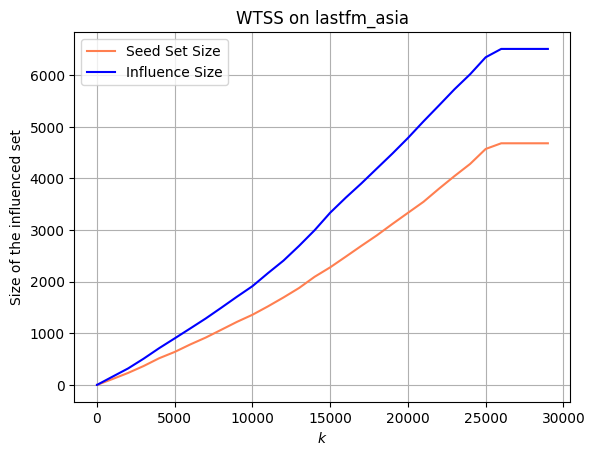

In [ ]:
plt.plot(ks, ss_sizes, label="Seed Set Size", color="coral")
plt.plot(ks, sizes, label="Influence Size", color="blue")
plt.xlabel("$k$")
plt.legend()
plt.ylabel("Size of the influenced set")
plt.title(f"{SS_STRATEGY.upper()} on {DATASET_NAME}")
plt.grid()

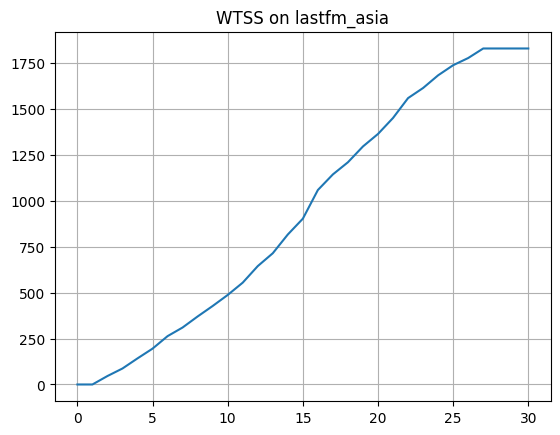

In [ ]:
plt.plot(np.array(sizes) - np.array(ss_sizes))
plt.title(f"{SS_STRATEGY.upper()} on {DATASET_NAME}")
plt.grid()